# Instalando a biblioteca do YOLO

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Tracking e geração de métricas com os dois algoritmos

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import matplotlib.pyplot as plt
import time

# Configurações
video_path = "video_teste1.mp4"
trackers = ["botsort.yaml", "bytetrack.yaml"]
metrics = {}

# Carrega o modelo uma única vez (evita overhead)
model = YOLO("best.pt")

for tracker_name in trackers:
    print(f"\n--- Processando com {tracker_name} ---")

    cap = cv2.VideoCapture(video_path)
    track_history = defaultdict(list)
    active_tracks = set()
    id_switches = defaultdict(int)
    track_durations = defaultdict(int)
    frame_count = 0
    total_time = 0

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        start_time = time.time()  # Mede o tempo por frame

        # Usa o mesmo modelo, apenas muda o tracker
        results = model.track(frame, persist=True, tracker=tracker_name)[0]

        frame_count += 1
        frame_time = (time.time() - start_time) * 1000  # ms
        total_time += frame_time

        if results.boxes and results.boxes.id is not None:
            current_ids = results.boxes.id.int().cpu().tolist()

            for tid in active_tracks - set(current_ids):
                id_switches[tid] += 1

            active_tracks = set(current_ids)

            for tid in current_ids:
                track_durations[tid] += 1

    avg_time_per_frame = total_time / frame_count
    total_switches = sum(id_switches.values())
    avg_duration = np.mean(list(track_durations.values())) if track_durations else 0

    metrics[tracker_name] = {
        "total_ids": len(track_durations),
        "id_switches": total_switches,
        "avg_duration": avg_duration,
        "avg_time_ms": avg_time_per_frame,
    }

    cap.release()


--- Processando com botsort.yaml ---

0: 384x640 3 cows, 71.9ms
Speed: 2.5ms preprocess, 71.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cows, 67.2ms
Speed: 3.5ms preprocess, 67.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cows, 40.5ms
Speed: 3.4ms preprocess, 40.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cows, 40.3ms
Speed: 3.9ms preprocess, 40.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cows, 40.7ms
Speed: 3.3ms preprocess, 40.7ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cows, 45.2ms
Speed: 3.6ms preprocess, 45.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cows, 43.0ms
Speed: 7.8ms preprocess, 43.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cows, 43.0ms
Speed: 3.4ms preprocess, 43.0ms inference, 2.5ms postprocess per im

In [ ]:
# Exibe métricas
print("\n--- Métricas Finais ---")
for tracker, data in metrics.items():
    print(f"\nTracker: {tracker}")
    print(f"- Tempo médio por frame: {data['avg_time_ms']:.2f} ms")
    print(f"- IDs únicos: {data['total_ids']}")
    print(f"- Trocas de ID: {data['id_switches']}")
    print(f"- Duração média (frames): {data['avg_duration']:.2f}")


--- Métricas Finais ---

Tracker: botsort.yaml
- Tempo médio por frame: 92.26 ms
- IDs únicos: 15
- Trocas de ID: 27
- Duração média (frames): 96.73

Tracker: bytetrack.yaml
- Tempo médio por frame: 88.85 ms
- IDs únicos: 15
- Trocas de ID: 27
- Duração média (frames): 96.60


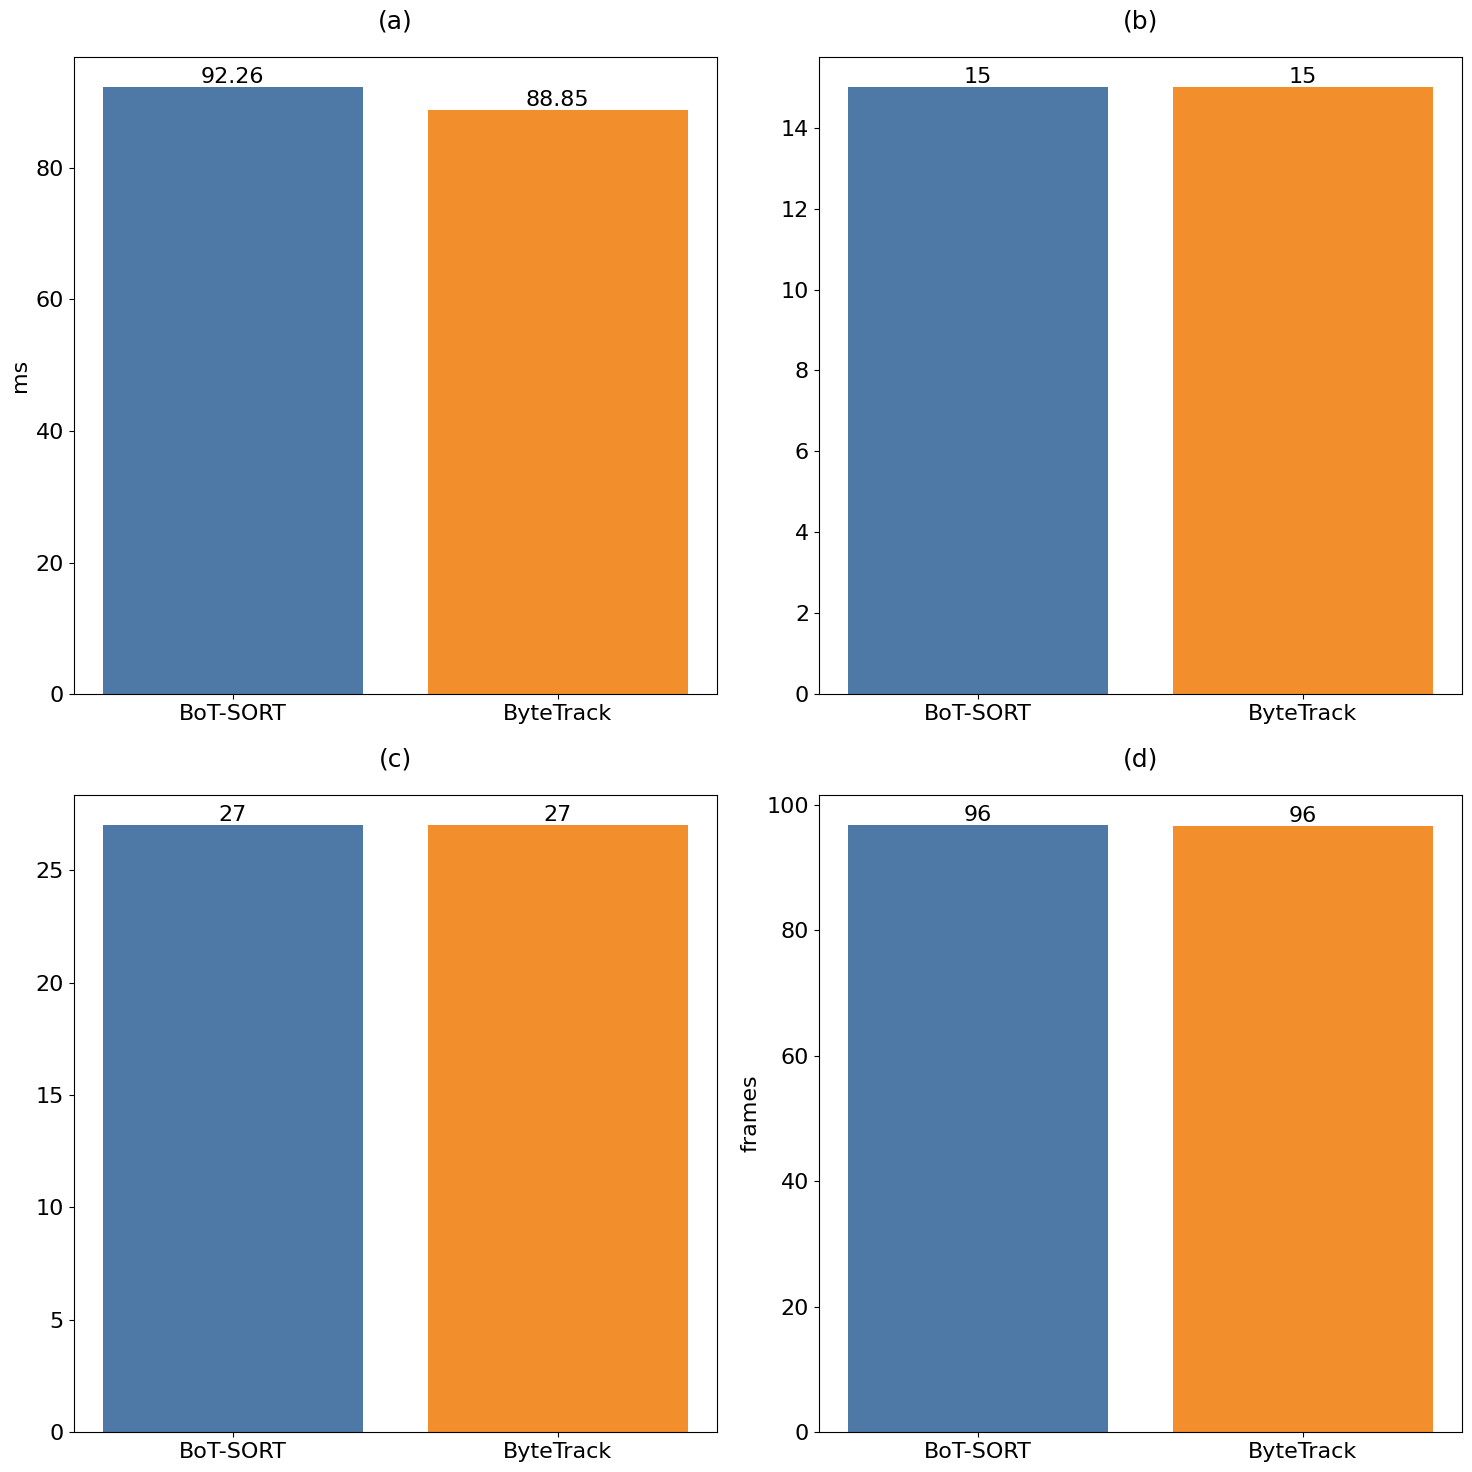

In [ ]:
import matplotlib.pyplot as plt

# Configurações
trackers_display = {"botsort.yaml": "BoT-SORT", "bytetrack.yaml": "ByteTrack"}
trackers = [trackers_display[t] for t in metrics.keys()]  # Nomes formatados
labels = ["avg_time_ms", "total_ids", "id_switches", "avg_duration"]
titles = ["(a)", "(b)",
          "(c)", "(d)"]
colors = ['#4e79a7', '#f28e2b']

# Cria figura e subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # Tamanho quadrado
axes = axes.ravel()  # Transforma em array 1D para facilitar iteração

# Ajuste global de fonte
plt.rcParams.update({'font.size': 16})

# Plotagem
for i, (label, title) in enumerate(zip(labels, titles)):
    ax = axes[i]
    values = [metrics[list(metrics.keys())[idx]][label] for idx in range(len(trackers))]
    bars = ax.bar(trackers, values, color=colors)

    # Configurações do subplot
    ax.set_title(title, fontsize=18, pad=20)  # Pad ajusta espaçamento
    ax.tick_params(axis='both', labelsize=16)

    # Adiciona valores nas barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}' if label == "avg_time_ms" else f'{int(height)}',
                ha='center', va='bottom', fontsize=16)

    # Rótulos personalizados para os eixos Y
    if label == "avg_time_ms":
        ax.set_ylabel("ms", fontsize=16)
    elif label == "avg_duration":
        ax.set_ylabel("frames", fontsize=16)

# Ajustes finais
plt.tight_layout()
plt.savefig("comparacao_trackers_final.png", dpi=300, bbox_inches='tight')
plt.show()